In [1]:
import sys
sys.path.append('../../')

In [2]:
from definitions import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from notebooks.nb_imports import *

In [3]:
# Raw dataframe
df = load_pickle(ROOT_DIR + '/data/interim/munged/df.pickle')
labels = load_pickle(ROOT_DIR + '/data/processed/labels/original.pickle')

/Users/jambo/miniconda3/lib/python3.7/site-packages/pandas/core/indexes/base.py:183: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return cls.__new__(cls, **d)


# Sepsis onset time
Here we give the number of cases that sepsis becomes onset at each time t. That is, the first occuring 1.

In [4]:
# Calculate first time of sepsis onset
sepsis_all = labels[labels == 1]
sepsis_first = sepsis_all.groupby(['id']).apply(lambda x: x.iloc[[0]])
first_times = pd.Series(sepsis_first.index.get_level_values('time'))

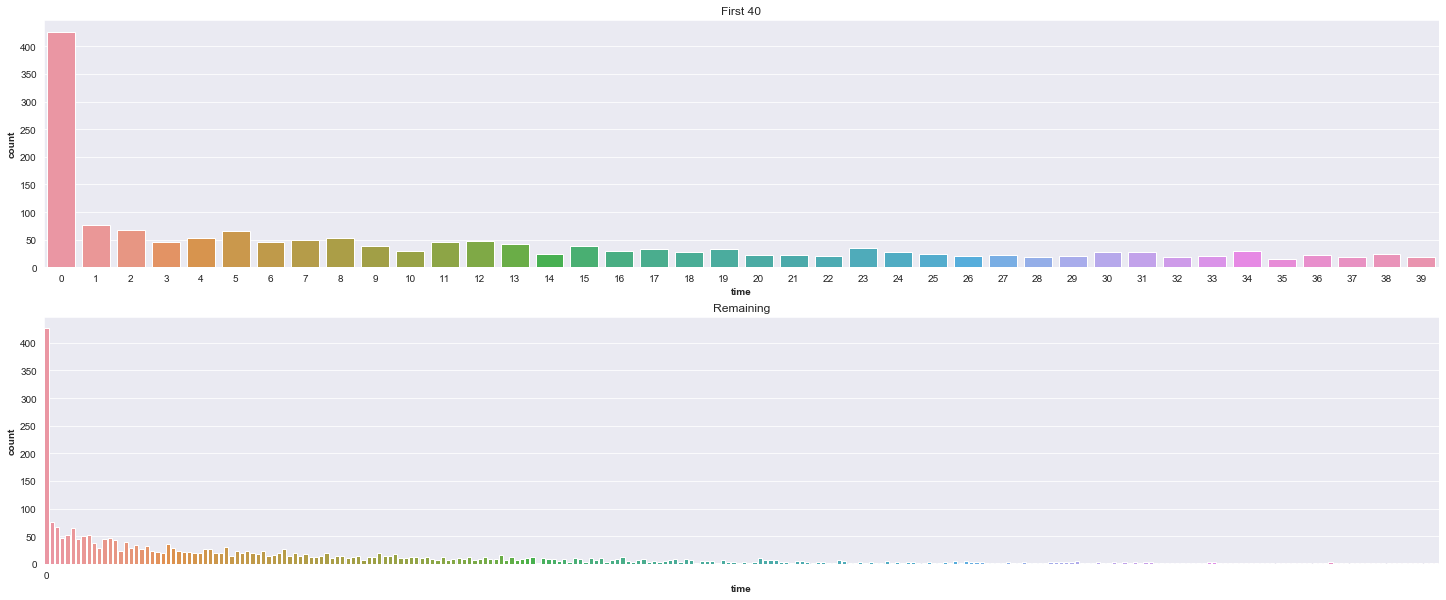

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(25, 10))
ax = ax.ravel()

ax[0].set_title('First 40')
sns.countplot(x=first_times.index, data=first_times, order=first_times.iloc[0:40].index, ax=ax[0])

ax[1].set_title('Remaining')
sns.countplot(x=first_times.index, data=first_times, ax=ax[1])
ax[1].set_xticks([0]);

# Location of ones in the df
Now we give the total number of 1s in the dataset for each time

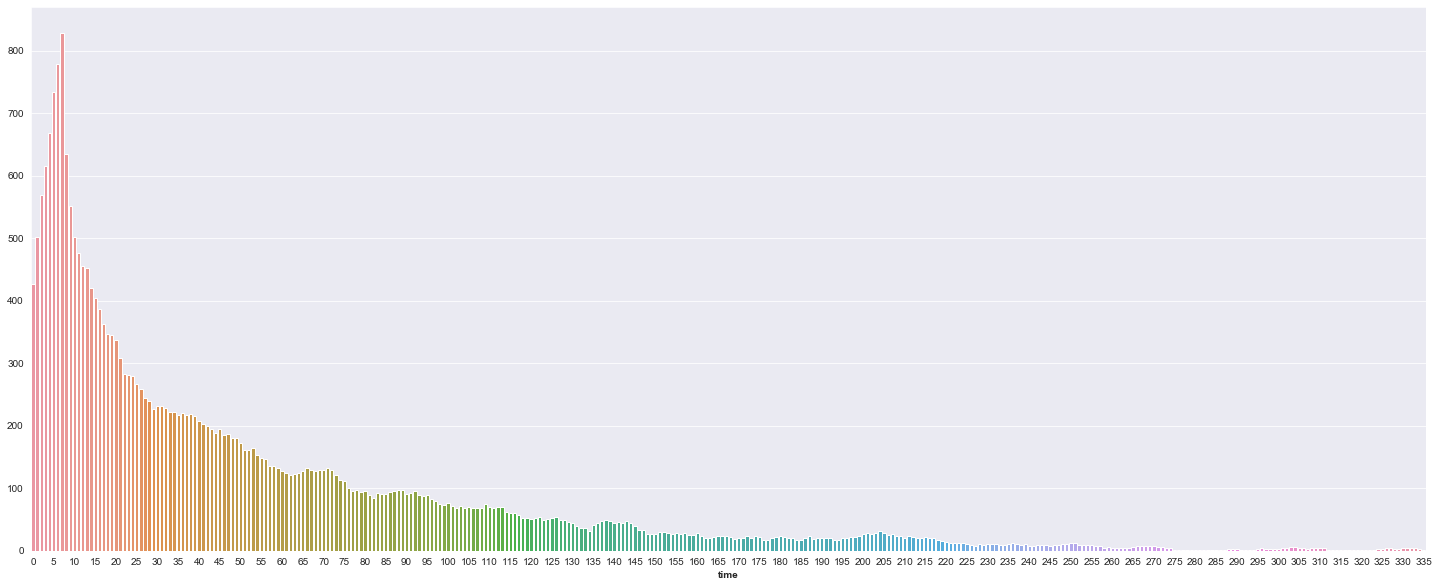

In [6]:
# Setup the plot
fig, ax = plt.subplots(1, 1, figsize=(25, 10))

# Total ones for each timepoint and barplot
total_ones = labels.groupby('time').apply(sum)

# Plot
sns.barplot(x=total_ones.index, y=total_ones.values, ax=ax)
remove_plot_ticks(ax)

# Ratio of ones to zeros

> There seem to be two distinctive regions either side of t=~58.

> Proposition: use algorithms in each of the two regions.

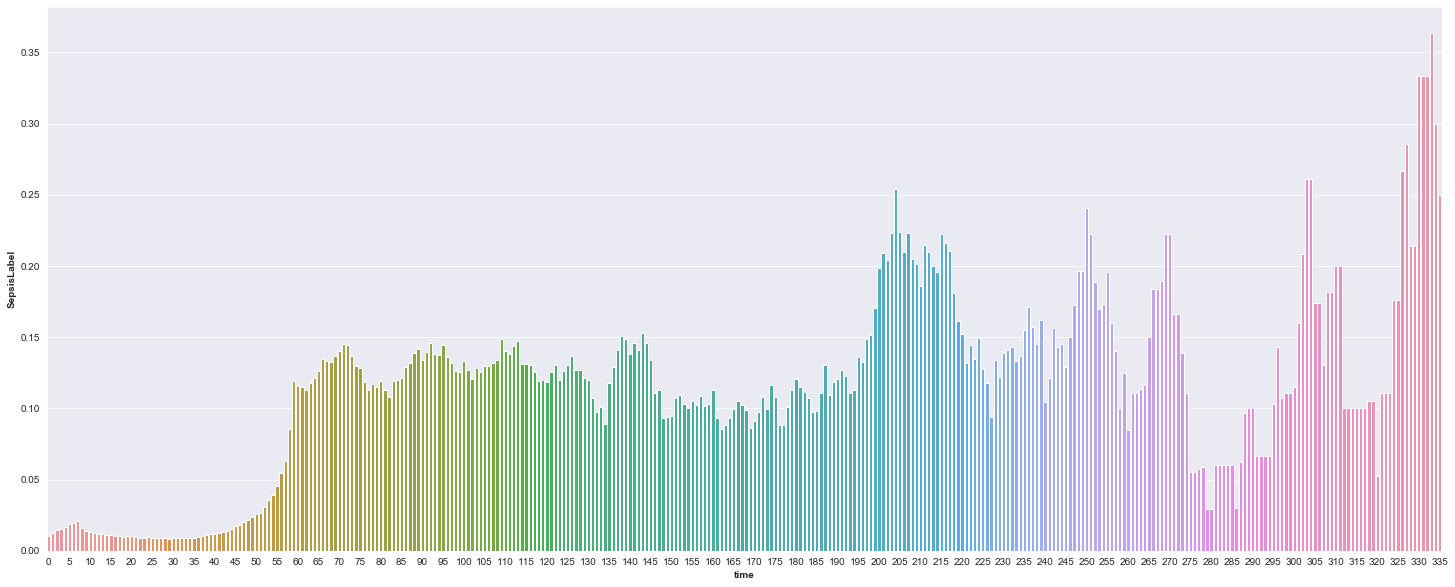

In [7]:
plot_label_zero_to_one_ratio(labels);

**An interesting piece of analysis**

If you survive over 60 hours, the chances of you getting sepsis is over 4/5

In [8]:
a = labels.loc[df.query('time >= 60').index.get_level_values('id').unique()]
num_in_icu = len(a.index.get_level_values('id').unique())
num_that_get_sepsis = len(a[a > 0].index.get_level_values('id').unique())
print('{} people are in the icu for more than 60 hours'.format(num_in_icu))
print('Of those, {} eventually get sepsis'.format(num_that_get_sepsis))
print('This is {:.3f}%'.format(100 * num_that_get_sepsis / num_in_icu))

1232 people are in the icu for more than 60 hours
Of those, 1008 eventually get sepsis
This is 81.818%


**Closer look at the t~58 region**

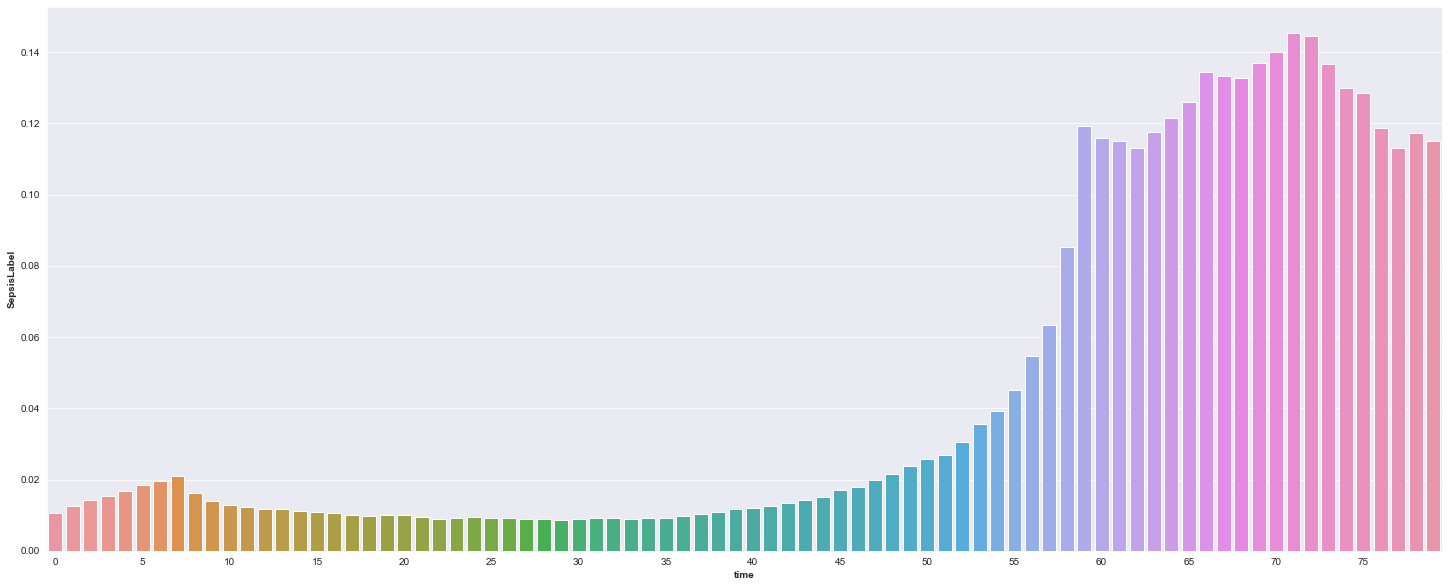

In [9]:
plot_label_zero_to_one_ratio(labels, first_n=80);

## Hospital comparison
We want to see if both hospitals have this peak at 58. We find:

> A peak exists for both hospitals, it is much more pronounced for hospital 1

> It seems resonable to assume we can separate these two regions and consider different algorithms for each one

In [11]:
labels_1, labels_2 = labels[df['hospital'] == 1], labels[df['hospital'] == 2]

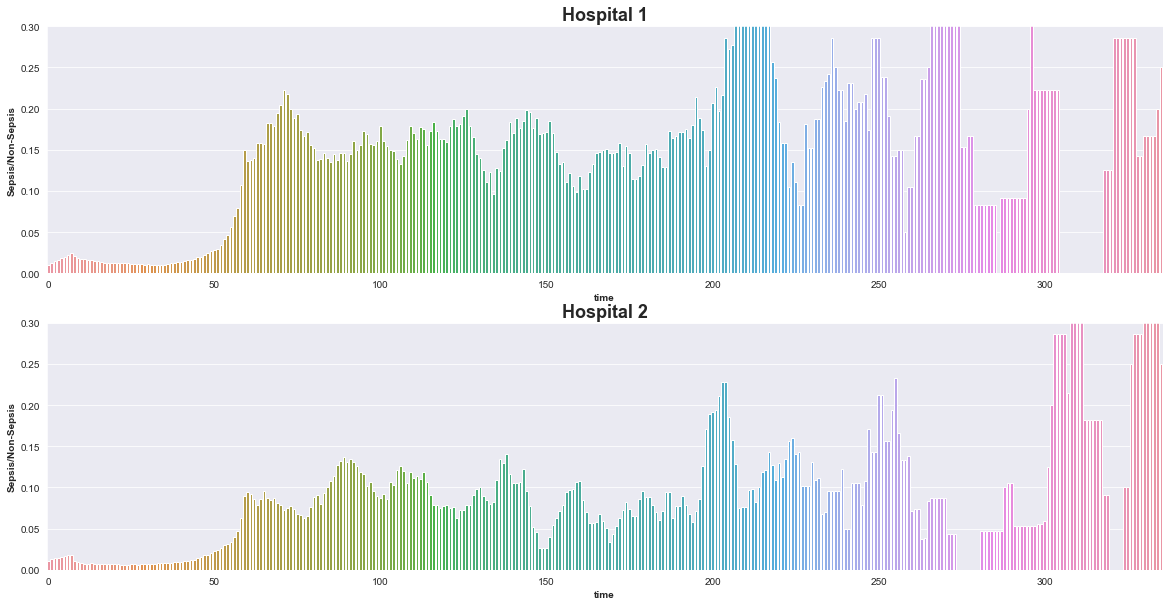

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

plot_label_zero_to_one_ratio(labels_1, ax=ax[0])

plot_label_zero_to_one_ratio(labels_2, ax=ax[1])


# Some plot setup
ax[0].set_title('Hospital 1', fontweight='bold', fontsize=18)
ax[0].set_ylim([0, 0.3])
ax[0].set_ylabel('Sepsis/Non-Sepsis')
ax[1].set_title('Hospital 2', fontweight='bold', fontsize=18)
ax[1].set_ylim([0, 0.3])
ax[1].set_ylabel('Sepsis/Non-Sepsis')

# Remove ticks
remove_plot_ticks(ax[0], 10)
remove_plot_ticks(ax[1], 10)

plt.savefig('./figures/hospital_sepsis_ratios.png', dpi=300, bbox_inches='tight')

# Sepsis is approximately stationary (like a poisson process)
The above plots suggest that the arrival of sepsis may come from a susceptible population at an approximately constant rate. Here we test that hypothesis.

Below we plot the ratio of septic to non-septic labels for patients who eventually develop sepsis. The results strongly support the hypothesis of there being an initial susceptible population who get sepsis at some approximately constant rate.  

(0, 0.5)

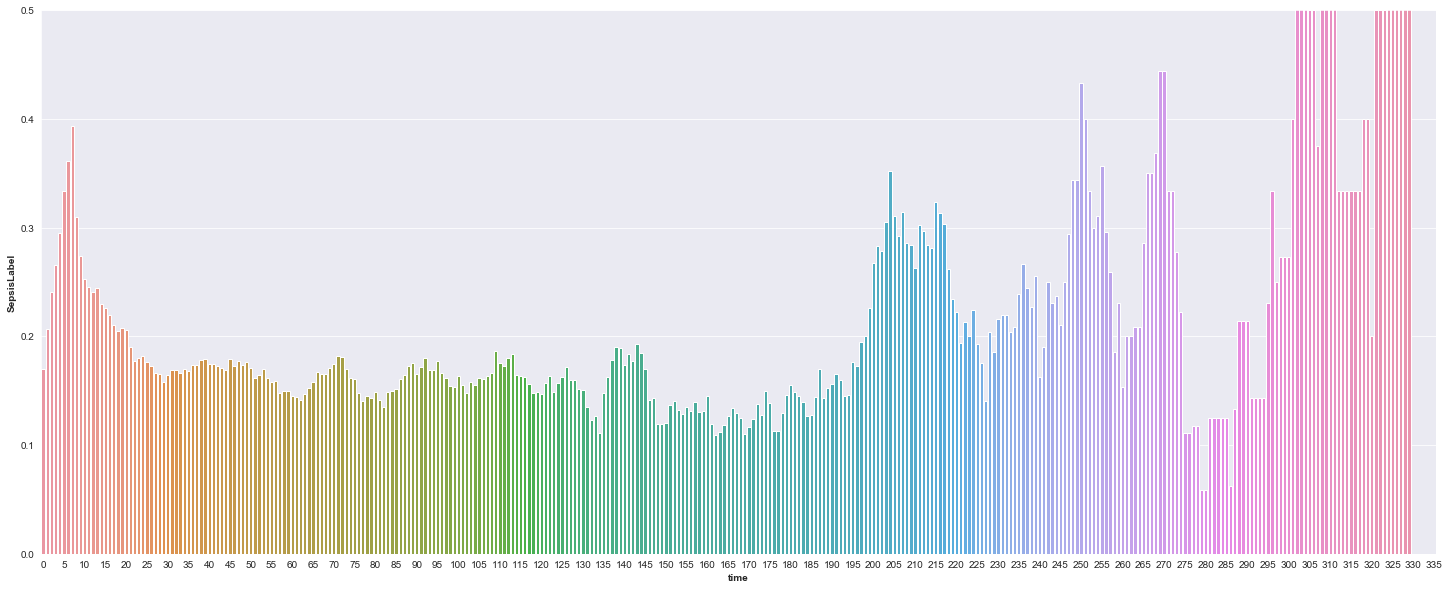

In [11]:
ids = labels[labels > 0].index.get_level_values('id')
ax = plot_label_zero_to_one_ratio(labels.loc[ids])
ax.set_ylim([0, 0.5])

## Hospital 1

In [8]:
labels_1, labels_2 = labels[df['hospital'] == 1], labels[df['hospital'] == 2]

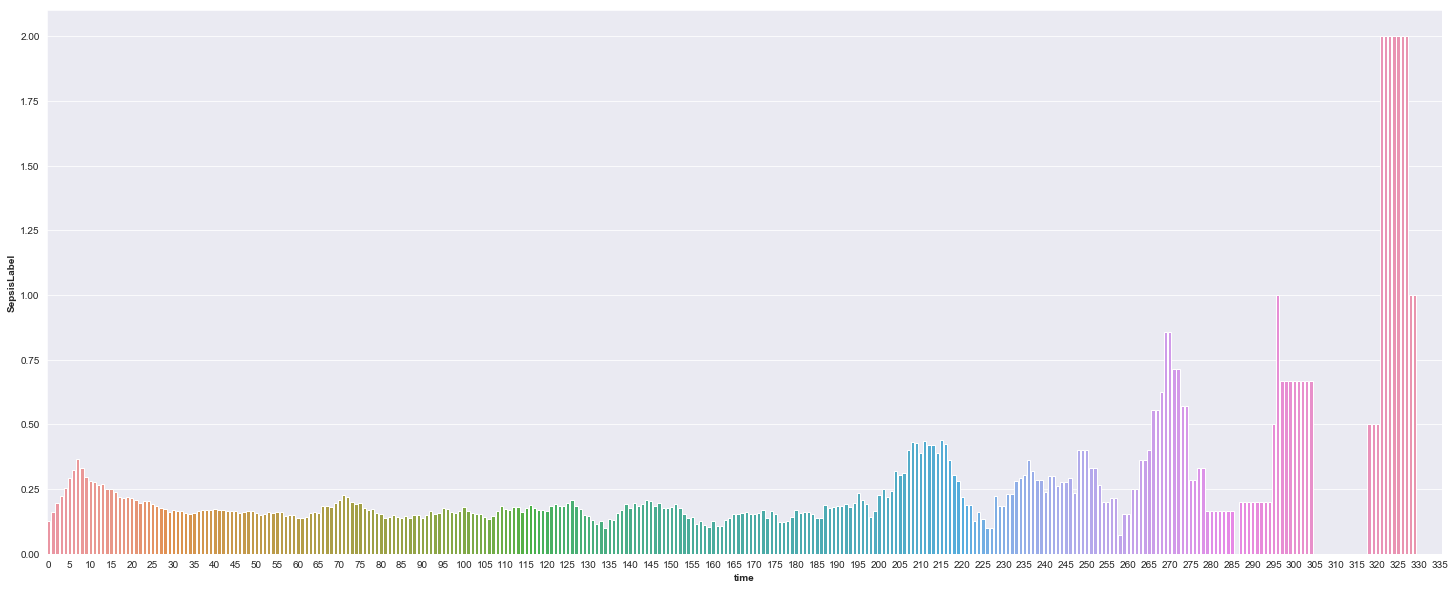

In [9]:
ids = labels_1[labels_1 > 0].index.get_level_values('id')
ax = plot_label_zero_to_one_ratio(labels_1.loc[ids])

## Hospital 2

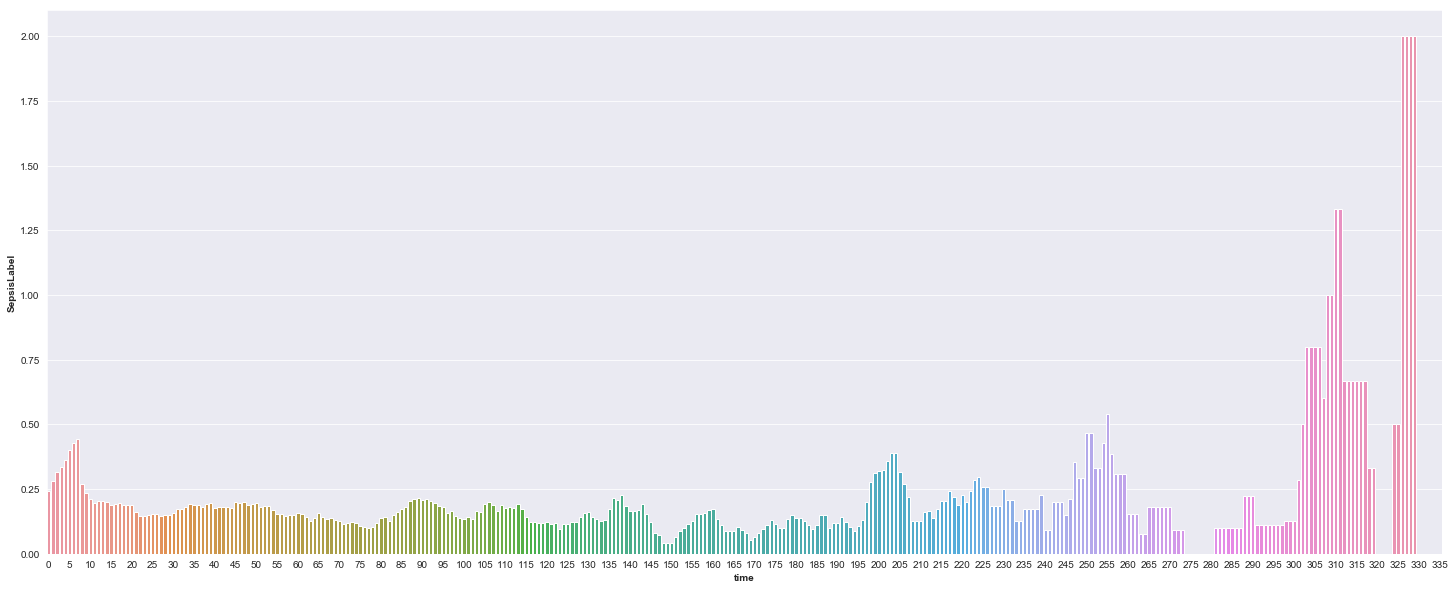

In [10]:
ids = labels_2[labels_2 > 0].index.get_level_values('id')
ax = plot_label_zero_to_one_ratio(labels_2.loc[ids])

# Sepsis with regards to other variables

## Gender

In [8]:
labels_1, labels_2 = labels[df['Gender'] == 1], labels[df['Gender'] == 0]

### Male

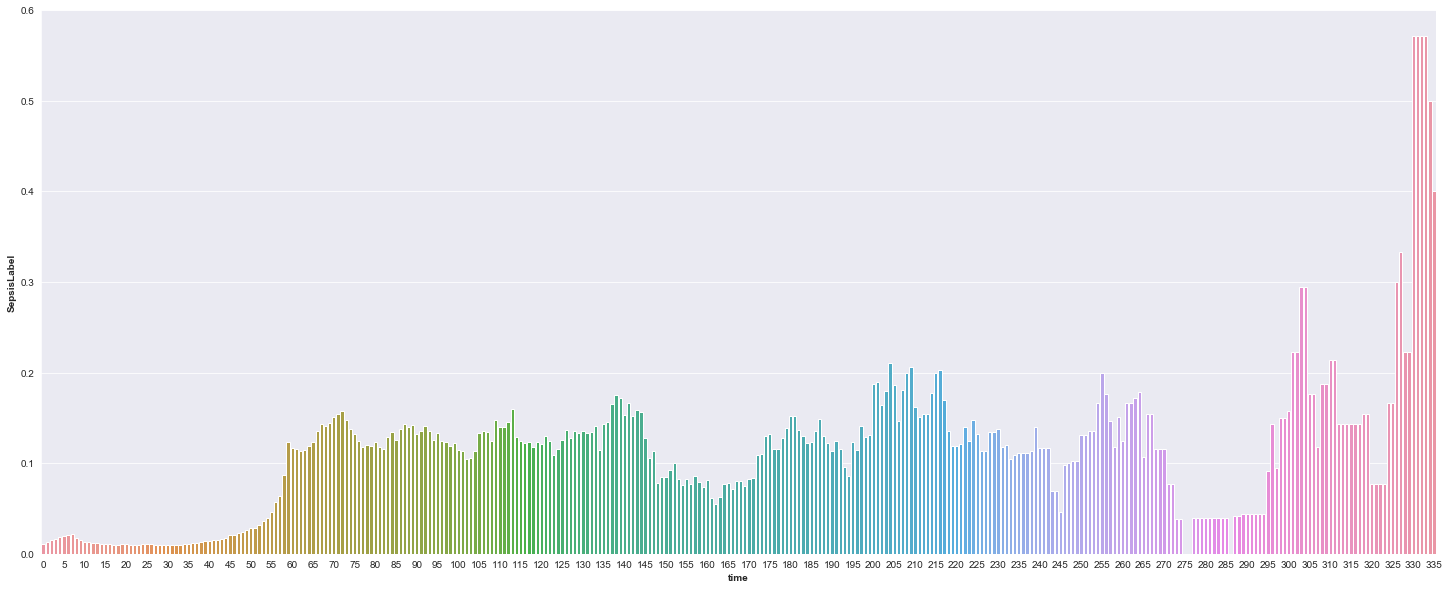

In [9]:
ax = plot_label_zero_to_one_ratio(labels_1)

### Female

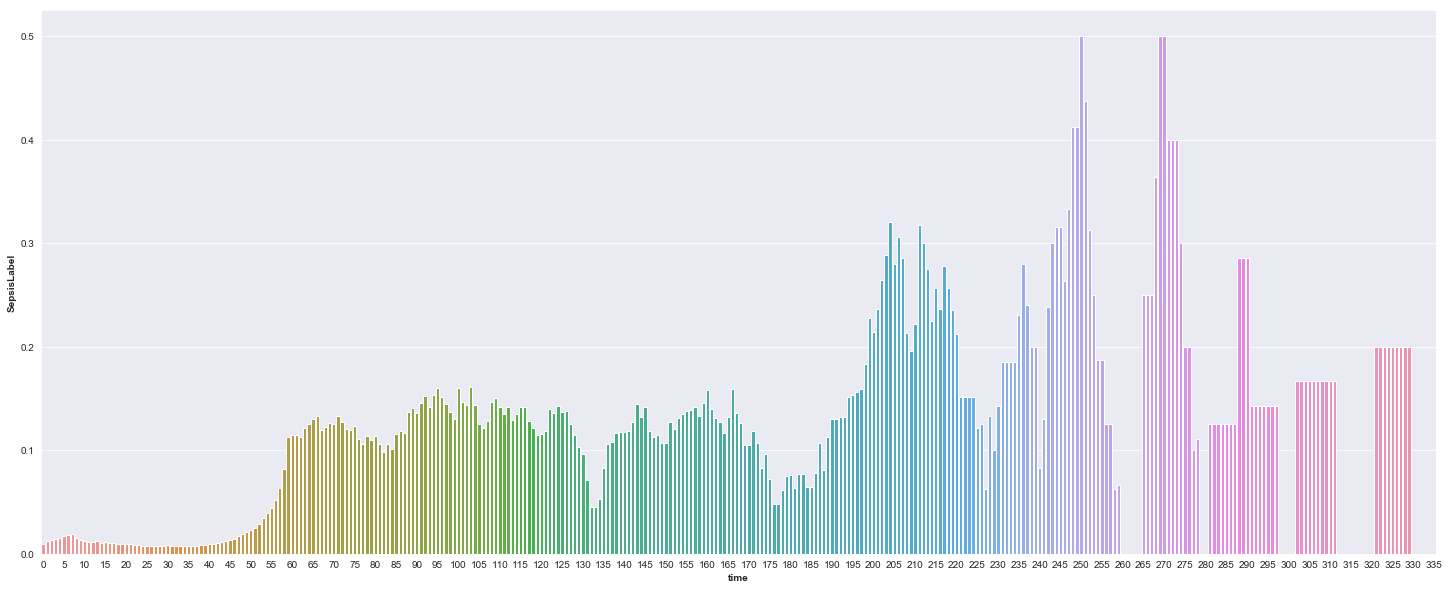

In [10]:
ax = plot_label_zero_to_one_ratio(labels_2)

## Age

### Younger than 25

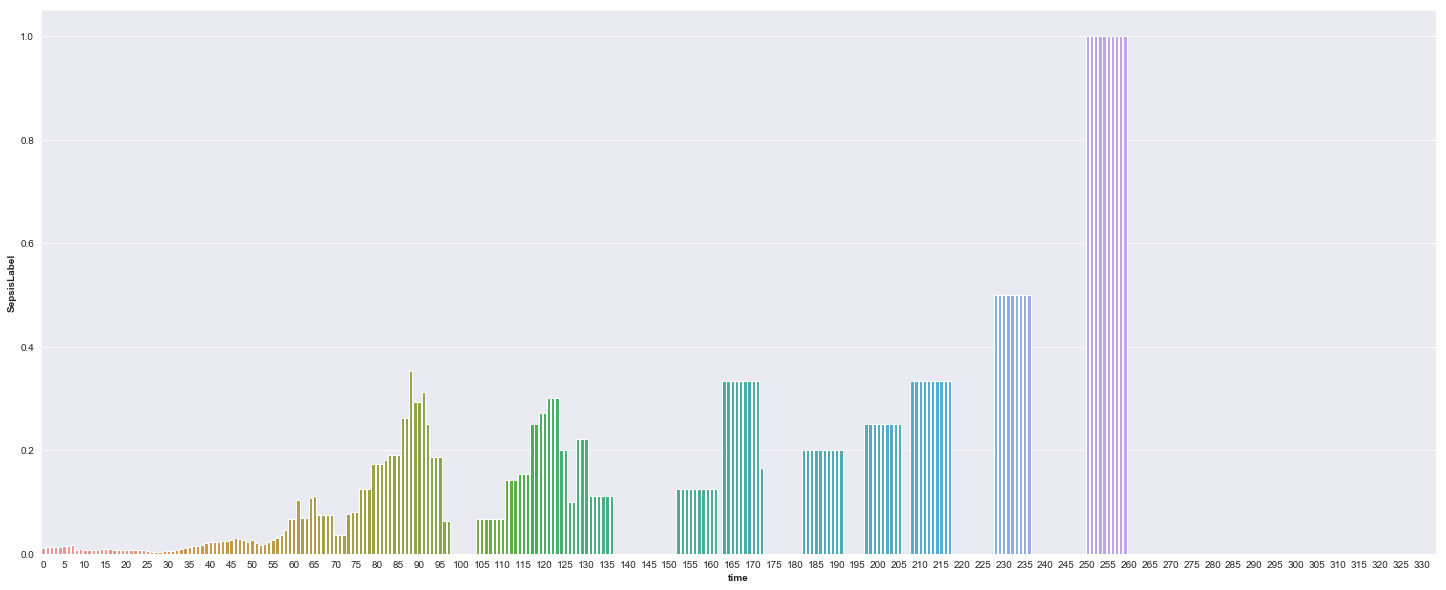

In [20]:
ax = plot_label_zero_to_one_ratio(labels[df['Age'] < 25])

In [22]:
print(len(labels_1.index.get_level_values('id').unique()))

1046


### Older than 70

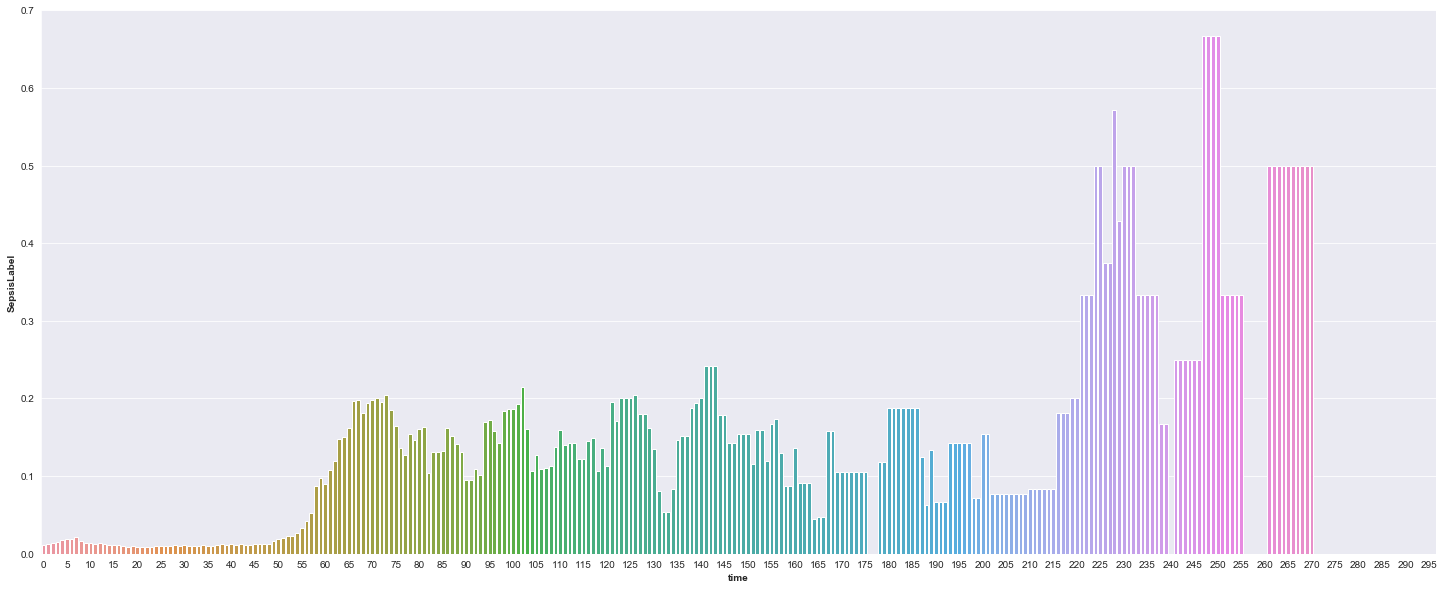

In [34]:
ax = plot_label_zero_to_one_ratio(labels[df['Age'] >= 80])

### Middle aged

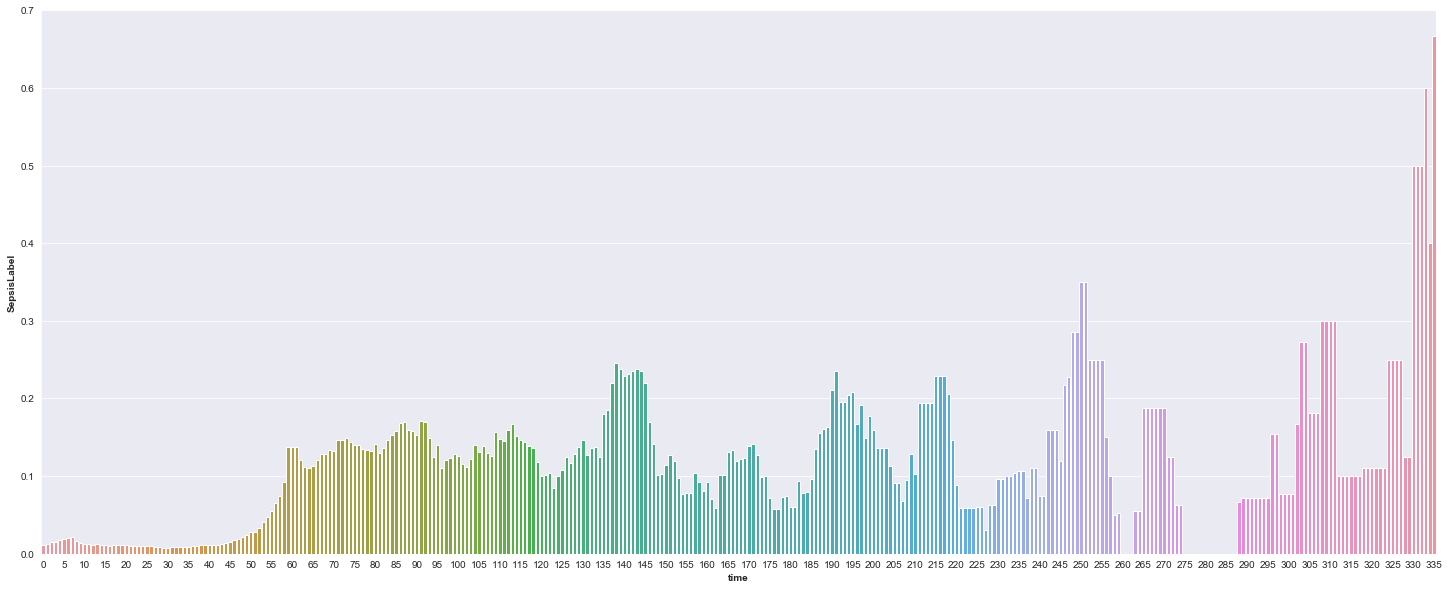

In [31]:
ax = plot_label_zero_to_one_ratio(labels[(df['Age'] > 20) & (df['Age'] < 60)])

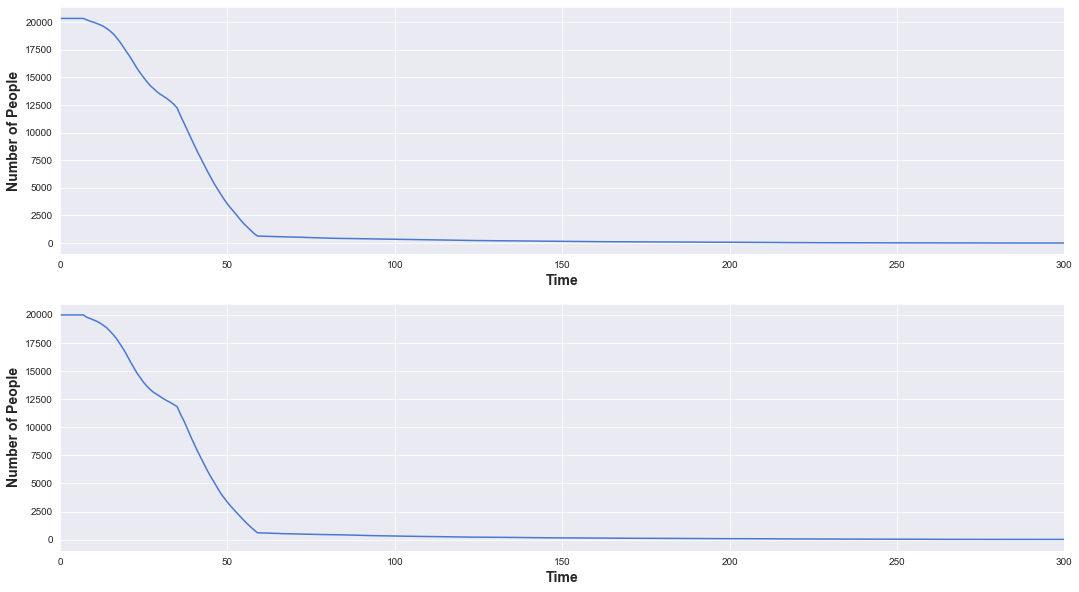

In [39]:
fig, ax = plt.subplots(2, figsize=(18, 10))

for i in [1, 2]:
    times = pd.Series(list(labels[df['hospital'] == i].index.get_level_values('time'))).value_counts().sort_index()


    ax[i-1].plot(times)
    ax[i-1].set_xlabel('Time', fontsize=14)
    ax[i-1].set_ylabel('Number of People', fontsize=14)
    ax[i-1].set_xlim([0, 300])
    plt.savefig('./figures/hosp_decomission_rates.png', dpi=300, bbox_inches='tight')